## <a id="Описание-данных"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span>
    Обнаружение каверов музыкальных треков</div>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:80%;
                                                 font-size:120%;
                                                 text-align: left;">


Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. 

</div>

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #294B8E"> Описание данных</p>

<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;</li>
<li>original_track_id - уникальный идентификатор исходного трека.</li>
</ul>

<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>lyricId - уникальный идентификатор текста;</li>
<li>text - текст трека.</li>
</ul>

<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>dttm - первая дата появления информации о треке;</li>
<li>title - название трека;</li>
<li>language - язык исполнения;
<li>isrc - международный уникальный идентификатор трека;</li>
<li>genres - жанры;</li>
<li>duration - длительность трека;</li>
</ul>

# Загрузка библиотек

In [64]:
import re
import torch
import transformers
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from catboost import CatBoostClassifier
from transformers import BertModel, BertForMaskedLM
from transformers import BertTokenizer
from tqdm import notebook

from numpy import asarray
from numpy import savetxt

# Загрузка данных, EDA

In [3]:
meta = pd.read_json('D:/programs/projects/yandex_music/meta.json', lines= True, convert_dates=['dttm'])
meta.info()
display(meta.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
12000,265bbc80c02e68574ddbb40e8c12a71b,2022-06-21 14:51:18,Regresa,None,QZNJV2245781,[RAP],204960.0
52282,23d94be45def834768ca8ee86c3dfaf9,2017-04-26 02:20:18,River of Jordan,EN,FR2X41779317,[FOLKGENRE],158450.0
53553,497ef3a440c2abaafd366b7336b7458e,2020-06-25 00:18:23,Tu de Que Vas,None,QZHZ52004865,"[FOLK, LATINFOLK]",219250.0
19457,dbe939989a9b3a72f613fb4100964b72,2020-05-01 23:36:17,The Song You Heard Somewhere,EN,USDY42080643,[RAP],116840.0
8492,036b9190dadd1b8fb5e06bd448269642,2022-03-30 20:48:19,Ogum,None,QZHZ32285204,"[FOLK, LATINFOLK]",254040.0


In [4]:
#load covers
covers = pd.read_json('D:/programs/projects/yandex_music/covers.json', lines= True)
covers.info()
display(covers.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
40496,None,9e0ab97c442821e93feaa24aefda6fc1,COVER
55971,None,451094e525ea52259ec0be07ac4ee635,COVER
51163,None,09cd3361d1d45e51bef03db2541e46ef,COVER
55515,None,3d59cee8a411e7fea938d8258739977f,COVER
24134,None,a5a6677b47b7510cf00af0a6c78b9471,COVER


In [5]:
#load lyrics
lyrics = pd.read_json('D:/programs/projects/yandex_music/lyrics.json', lines= True)
lyrics.info()
display(lyrics.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
253,d844784bd000f26cf2ce2e579c29dc9e,"Мы с тобой в этом море, тони\nГде опять без те...",dcb5c18545dbd6faa550b63f239daeb8
1188,3605b420135154c45459ee96ba245f1f,Всё решено за меня\nВсё решено за меня\nВсё ре...,3f5cf22e999be73a1bbf3cc1db85205e
8369,6e670f3f416396653024ab4dd8a62647,"Beggin', beggin' you\nPut your loving hand out...",dd4d1559e4cb21ca66293a501e206a38
3398,ec20b52f037475029e8559390c1d3893,Another head hangs lowly\nChild is slowly take...,5c83f86a814ac5f3abbfddc4c889ffc7
10714,2e8590e847228a3f81fe4775908017d4,Girl of sixteen\nWhole life ahead of her\nSlas...,ac4fe9b2439baece6730a2fa1ac39eaf


# Предобработка данных

In [6]:
lyrics.duplicated('track_id').sum()

1137

In [7]:
lyrics.drop_duplicates(subset=['track_id'], inplace=True)

In [8]:
lyrics.duplicated('track_id').sum()

0

In [9]:
meta['isrc'] = meta['isrc'].str.replace("-","")
meta.drop_duplicates(subset = 'isrc', ignore_index = True)
meta = meta.dropna(subset=['isrc']).reset_index(drop=True)
meta['isrc_year'] = meta['isrc'].str[5:7]
meta = meta.astype({'isrc_year':'int'})
for i in range(len(meta.index)):
    if meta.loc[i,'isrc_year']>23:
        meta.loc[i,'isrc_year'] = meta.loc[i,'isrc_year']+1900
    else:
        meta.loc[i,'isrc_year'] = meta.loc[i,'isrc_year']+2000
print(meta['isrc_year'].unique())

[2021 2018 2020 2022 2019 1999 2001 2000 2017 2016 2014 2012 2008 2005
 2015 2009 1982 1930 1933 1977 1936 1935 1950 1962 2004 1970 1966 2006
 2010 1996 1995 2023 2007 2011 2003 2013 2002 1924 1981 1973 1960 1971
 1965 1938 1985 1998 1963 1990 1994 1987 1980 1978 1984 1988 1976 1974
 1979 1992 1989 1991 1986 1997 1983 1951 1993 1925 1942 1926 1969 1968
 1967 1975 1958 1954 1957 1944 1964]


In [10]:
df = pd.merge(meta, covers, how = 'outer', on="track_id").dropna(subset=['isrc'])
df = pd.merge(df, lyrics, how = 'outer', on="track_id").dropna(subset=['track_remake_type'])
df.reset_index(drop=True, inplace=True)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71287 entries, 0 to 71286
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           71287 non-null  object        
 1   dttm               71287 non-null  datetime64[ns]
 2   title              71287 non-null  object        
 3   language           21821 non-null  object        
 4   isrc               71287 non-null  object        
 5   genres             71287 non-null  object        
 6   duration           71287 non-null  float64       
 7   isrc_year          71287 non-null  float64       
 8   original_track_id  4729 non-null   object        
 9   track_remake_type  71287 non-null  object        
 10  lyricId            10063 non-null  object        
 11  text               10063 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 6.5+ MB


,track_id,dttm,title,language,isrc,genres,duration,isrc_year,original_track_id,track_remake_type,lyricId,text
7616,5a4340266f3e2fbc86a40ad1411dedd4,2022-03-29 06:00:00,Giant Steps,None,USLZJ2203861,[ELECTRONICS],160000.0,2022.0,None,COVER,NaN,NaN
25864,721b8fc556b2cf5a8f33df80736fbe1c,2021-06-28 16:18:20,Mi Árbol y Yo,None,QZHZ62127127,"[FOLK, LATINFOLK]",234370.0,2021.0,None,COVER,NaN,NaN
13283,4b5789215ed36b9a95b58f847aa7bf69,2023-04-06 21:00:00,Молодая,RU,FRX282254591,"[FOLK, CAUCASIAN]",156000.0,2022.0,4b5789215ed36b9a95b58f847aa7bf69,ORIGINAL,7fa4da85c32417f32fe9defb421abff5,"Она, как наступит вечер\nНавстречу, да распуст..."
54392,0414858835a35135b7629a557455a54b,2020-08-11 17:17:54,Friend Or Foe,None,ARHXW2003424,"[ALTERNATIVE, HARDCORE]",100860.0,2020.0,None,COVER,NaN,NaN
24828,acb444f943ef840e0387066d3ad287b6,2021-07-08 21:00:00,Don't Start Now,EN,QZHNC2101922,[ELECTRONICS],128260.0,2021.0,None,COVER,NaN,NaN


In [11]:
df.track_remake_type.value_counts()

track_remake_type
COVER       67083
ORIGINAL     4204
Name: count, dtype: int64

In [12]:
# Сначала создаем копию DataFrame, чтобы избежать изменения исходных данных
data = df.copy()
data.reset_index(drop=True, inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71287 entries, 0 to 71286
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           71287 non-null  object        
 1   dttm               71287 non-null  datetime64[ns]
 2   title              71287 non-null  object        
 3   language           21821 non-null  object        
 4   isrc               71287 non-null  object        
 5   genres             71287 non-null  object        
 6   duration           71287 non-null  float64       
 7   isrc_year          71287 non-null  float64       
 8   original_track_id  4729 non-null   object        
 9   track_remake_type  71287 non-null  object        
 10  lyricId            10063 non-null  object        
 11  text               10063 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 6.5+ MB
None


In [13]:
# Приводим все названия треков к нижнему регистру
data['title'] = data['title'].str.lower()

# Удаляем все знаки препинания и символы
data['title'] = data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [14]:
# Отбираем группы треков, где 'ORIGINAL' встречается больше 1 раза
groups_orig = data[data['track_remake_type'] == 'ORIGINAL'].groupby('title').filter(lambda x: len(x) > 1)
groups_orig.info()
groups_orig.title.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 152 to 71270
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           749 non-null    object        
 1   dttm               749 non-null    datetime64[ns]
 2   title              749 non-null    object        
 3   language           427 non-null    object        
 4   isrc               749 non-null    object        
 5   genres             749 non-null    object        
 6   duration           749 non-null    float64       
 7   isrc_year          749 non-null    float64       
 8   original_track_id  749 non-null    object        
 9   track_remake_type  749 non-null    object        
 10  lyricId            428 non-null    object        
 11  text               428 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 76.1+ KB


title
smooth criminal                                56
новогодняя                                     10
bagatelle no 25 in a minor woo 59 für elise    10
bright lights                                   7
blue lines                                      5
                                               ..
до встречи                                      2
shadow                                          2
временно                                        2
home                                            2
arcade                                          2
Name: count, Length: 305, dtype: int64

In [15]:
# Для каждой группы отмечаем самый ранний трек как 'ORIGINAL', а остальные помечаем как 'COVER'
# после этого действия некоторые трэки перестали быть оригиналами, а некоторые стали ими. 
#пока отмени его, переобучим модели
#for name, group in groups_orig.groupby('title'):
#    idx_min = group['isrc_year'].min()
#    data.loc[(data['title'] == name) & (data['isrc_year'] != idx_min), 'track_remake_type'] = 'COVER'
#    data.loc[(data['title'] == name) & (data['isrc_year'] == idx_min), 'track_remake_type'] = 'ORIGINAL'

In [16]:
# Снова проверим группы треков, где 'ORIGINAL' встречается больше 1 раза
groups_orig = data[data['track_remake_type'] == 'ORIGINAL'].groupby('title').filter(lambda x: len(x) > 1)
groups_orig.title.value_counts()

title
smooth criminal                                56
новогодняя                                     10
bagatelle no 25 in a minor woo 59 für elise    10
bright lights                                   7
blue lines                                      5
                                               ..
до встречи                                      2
shadow                                          2
временно                                        2
home                                            2
arcade                                          2
Name: count, Length: 305, dtype: int64

In [17]:
data.track_remake_type.value_counts()

track_remake_type
COVER       67083
ORIGINAL     4204
Name: count, dtype: int64

In [18]:
data.dropna(subset=['track_remake_type'], inplace=True)

In [19]:
data.loc[data['track_remake_type'] == 'ORIGINAL','original'] = 1
data.loc[data['track_remake_type'] == 'COVER','original'] = 0

In [20]:
data.original.value_counts()

original
0.0    67083
1.0     4204
Name: count, dtype: int64

In [21]:
data.to_csv('D:/programs/projects/yandex_music/data_final.csv')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<ul>
<li>В данных были дубликаты и пропуски, их немного, поэтому удалили. 
<li>Так же извлечем признак isrc_year - год добавления в базу данных isrc.
<li>Объединили данные, вынесли в отдельный датасет 
<li>Создали целевой признак original.
<ul>

# Подготовка данных для обучения

In [34]:
rand = 12345
train, valid = train_test_split(
    data, 
    test_size=0.4, 
    stratify = data['original'], 
    random_state = rand
)

valid, test = train_test_split(
    valid, 
    test_size=0.50, 
    stratify = valid['original'], 
    random_state = rand
)

In [35]:
x_train = train[['title','isrc_year', 'duration']]
y_train = train['original']
x_valid = valid[['title','isrc_year', 'duration']]
y_valid = valid['original']
x_test = test[['title','isrc_year', 'duration']]
y_test = test['original']
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(42772, 3)
(42772,)
(14257, 3)
(14257,)
(14258, 3)
(14258,)


In [36]:
y_test.sum()

841.0

## Подготовка числовых данных

In [37]:
#Векторизация численных признаков
numeric = ['isrc_year', 'duration']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train_num = scaler.transform(x_train[numeric])
x_valid_num = scaler.transform(x_valid[numeric])
x_test_num = scaler.transform(x_test[numeric])
print(x_train_num)

[[ 0.08193911  0.40727232]
 [ 0.26265892  0.16854146]
 [ 0.44337874  0.31142663]
 ...
 [ 0.44337874 -1.39712225]
 [-1.18309962 -1.29015713]
 [ 0.26265892  0.38839028]]


## Векторизация текстовых признаков

In [38]:
def x_text_vectorization(text_column, split):
    
    # Токенизация
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained("bert-base-multilingual-cased")
    tokenized = text_column.apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    # Создание эмбеддингов
    batch_size = 1
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())\

    x_text_featured = np.concatenate(embeddings)
    display(x_text_featured)

    # save numpy array
    savetxt('D:/programs/projects/yandex_music/x_{}_text.csv'.format(split),x_text_featured, delimiter=',')
    np.save('D:/programs/projects/yandex_music/x_{}_text.npy'.format(split), x_text_featured)
    return x_text_featured

In [39]:
x_train_text = x_text_vectorization(x_train['title'], 'train')
x_train_full = np.concatenate((x_train_num, x_train_text), axis=1)
print(len(x_train_full))
print(len(x_train_full[1]))

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 05706d8f-dce9-435e-8155-bb486d6a3b5f)')' thrown while requesting HEAD https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json


  0%|          | 0/42772 [00:00<?, ?it/s]

array([[ 0.09518978, -0.21201745, -0.11355963, ...,  0.1740785 ,
        -0.1606977 ,  0.00818294],
       [ 0.32914993, -0.4010536 ,  0.4414759 , ...,  0.2985618 ,
        -0.05930707,  0.10808551],
       [ 0.12265736, -0.05022805,  0.16761622, ...,  0.08119817,
        -0.01456324,  0.09820893],
       ...,
       [ 0.24317314, -0.36079946,  0.31464922, ...,  0.68531936,
        -0.2871141 ,  0.14938554],
       [ 0.06457002,  0.12834765,  0.30551597, ...,  0.7038545 ,
        -0.27120233,  0.41058034],
       [ 0.14641583, -0.231852  ,  0.30433002, ...,  0.2542312 ,
        -0.11909863,  0.2523602 ]], dtype=float32)

42772
770


In [41]:
x_valid_text = x_text_vectorization(x_valid['title'], 'valid')
x_valid_full = np.concatenate((x_valid_num, x_valid_text), axis=1)
print(len(x_valid_full))
print(len(x_valid_full[1]))

  0%|          | 0/14257 [00:00<?, ?it/s]

array([[ 0.12802514, -0.41706538,  0.7027436 , ...,  0.5056648 ,
        -0.4302702 ,  0.14624792],
       [ 0.2542023 , -0.15973295,  0.03528909, ...,  0.5965711 ,
        -0.08644968,  0.12980574],
       [ 0.21913366,  0.06397137,  0.4540342 , ...,  0.24409969,
        -0.16091877, -0.03241554],
       ...,
       [ 0.45572108,  0.01279464,  0.69643307, ...,  0.62831885,
        -0.24587177,  0.38283375],
       [ 0.08845918, -0.22501305,  0.46314764, ...,  0.4583931 ,
         0.3407607 ,  0.16983944],
       [ 0.0524671 , -0.09950498,  0.31766078, ...,  0.5218402 ,
         0.15663251,  0.12470602]], dtype=float32)

14257
770


In [42]:
x_test_text = x_text_vectorization(x_test['title'], 'test')
x_test_full = np.concatenate((x_test_num, x_test_text), axis=1)
print(len(x_test_full))
print(len(x_test_full[1]))

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7aeeb467-f6c1-41be-a02f-e068fd47ff5e)')' thrown while requesting HEAD https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json


  0%|          | 0/14258 [00:00<?, ?it/s]

array([[ 0.14136013,  0.00563031,  0.21183378, ...,  0.40644377,
         0.07135993,  0.11351111],
       [-0.22770932,  0.03047064,  0.06684686, ...,  0.3373019 ,
        -0.22563955,  0.05071715],
       [ 0.6045658 , -0.50815856,  0.57643163, ...,  0.86507326,
        -0.40993255, -0.16227454],
       ...,
       [ 0.02891416,  0.01413313,  0.24989207, ...,  0.10082699,
         0.08775073,  0.10309011],
       [-0.45301372, -0.476664  ,  0.00153509, ...,  0.527208  ,
         0.27725583,  0.20293176],
       [ 0.16693161,  0.07272813,  0.34771216, ...,  0.2186776 ,
         0.13206504,  0.20419076]], dtype=float32)

14258
770


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left"> Разделили данные на тренировочную, валидационную и тестовую выборки, создали массивы с векторами.

# Обучение и выбор моделей

## Logistic Regression

In [43]:
logreg = LogisticRegression(solver='lbfgs',
                            max_iter=10000,
                            #class_weight = 'balanced'
                           )
logreg.fit(x_train_full, y_train)

LogisticRegression(max_iter=10000)

In [45]:
logreg_predictions = logreg.predict(x_valid_full)
print(metrics.f1_score(y_valid, logreg_predictions))

0.45335389360061684


In [46]:
print(metrics.recall_score(y_valid, logreg_predictions))

0.34958382877526756


In [47]:
metrics.confusion_matrix(y_valid, logreg_predictions)

array([[13254,   162],
       [  547,   294]], dtype=int64)

In [48]:
log_predict_proba = cross_val_predict(logreg, x_valid_full, y_valid, cv=2, method='predict_proba')
print(log_predict_proba)

[[0.99400073 0.00599927]
 [0.9627085  0.0372915 ]
 [0.95857311 0.04142689]
 ...
 [0.99894711 0.00105289]
 [0.97228551 0.02771449]
 [0.99888267 0.00111733]]


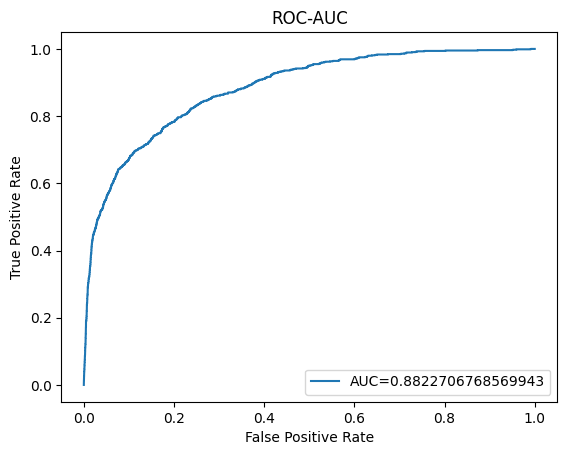

<Figure size 600x400 with 0 Axes>

In [49]:
log_predict_proba1 = log_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, log_predict_proba1)
auc = metrics.roc_auc_score(y_valid, log_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

In [50]:
f1_score = 0.0
threshold = 0.1
for thresh in range(1, 10):
    predict_cv_proba = (log_predict_proba1 >= thresh/10).astype(bool) 
    print(metrics.f1_score(y_valid, predict_cv_proba))
    if f1_score<metrics.f1_score(y_valid, predict_cv_proba):
        threshold = thresh/10
        f1_score = metrics.f1_score(y_valid, predict_cv_proba)
print(threshold)

0.4229007633587786
0.4782608695652174
0.4963054187192119
0.49552649690295936
0.44712990936555896
0.4118129614438064
0.35335689045936397
0.2876064333017975
0.15932914046121593
0.3


In [51]:
predict_log = logreg.predict(x_valid_full)
print(predict_log)
print(predict_log.sum())
print(y_test.sum())
print(metrics.f1_score(y_valid, predict_log))

[0. 0. 0. ... 0. 0. 0.]
456.0
841.0
0.45335389360061684


In [52]:
predict_final = (logreg.predict_proba(x_valid_full)[:,1] >= threshold).astype(bool) 
print(predict_final)
print(predict_final.sum())
print(y_valid.sum())
print(metrics.f1_score(y_valid, predict_final))

[False False False ... False False False]
732
841.0
0.5187539732994279


In [53]:
metrics.confusion_matrix(y_valid, predict_final)

array([[13092,   324],
       [  433,   408]], dtype=int64)

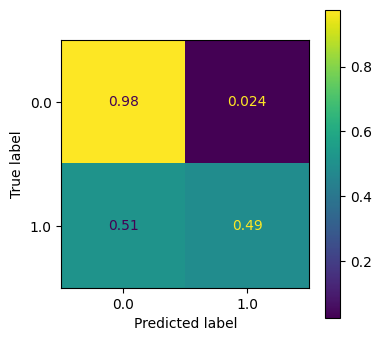

In [54]:
cm = metrics.confusion_matrix(y_valid, predict_final, labels=logreg.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=logreg.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


## Lightgbm

In [55]:
from lightgbm import LGBMClassifier

In [56]:
lgbm = LGBMClassifier()
lgbm.fit(x_train_full, y_train)

[LightGBM] [Info] Number of positive: 2522, number of negative: 40250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196135
[LightGBM] [Info] Number of data points in the train set: 42772, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058964 -> initscore=-2.770058
[LightGBM] [Info] Start training from score -2.770058


LGBMClassifier()

In [57]:
lgbm_predictions = lgbm.predict(x_valid_full)
print(metrics.f1_score(y_valid, lgbm_predictions))

0.5221374045801527


In [58]:
lgbm_predict_proba = cross_val_predict(lgbm, x_valid_full, y_valid, cv=2, method='predict_proba')
print(lgbm_predict_proba)

[LightGBM] [Info] Number of positive: 420, number of negative: 6708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196131
[LightGBM] [Info] Number of data points in the train set: 7128, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058923 -> initscore=-2.770801
[LightGBM] [Info] Start training from score -2.770801
[LightGBM] [Info] Number of positive: 421, number of negative: 6708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196133
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059055 -> initscore=-2.768423
[LightGBM] [Info] Start training from score -2.768423
[[9.93209121e-

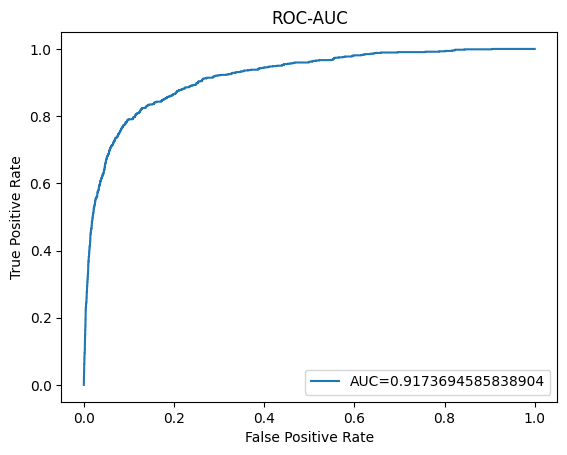

<Figure size 600x400 with 0 Axes>

In [59]:
lgbm_predict_proba1 = lgbm_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, lgbm_predict_proba1)
auc = metrics.roc_auc_score(y_valid, lgbm_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

In [60]:
f1_score = 0.0
threshold = 0.1
for thresh in range(1, 10):
    predict_cv_proba = (lgbm_predict_proba1 >= thresh/10).astype(bool) 
    print(metrics.f1_score(y_valid, predict_cv_proba))
    if f1_score<metrics.f1_score(y_valid, predict_cv_proba):
        threshold = thresh/10
        f1_score = metrics.f1_score(y_valid, predict_cv_proba)
print(threshold)

0.5544809800128949
0.5102639296187683
0.4554140127388535
0.4164567590260285
0.38782608695652177
0.35433789954337896
0.3076923076923077
0.2485089463220676
0.16578108395324123
0.1


In [61]:
predict_lgbm = lgbm.predict(x_valid_full)
print(predict_lgbm)
print(predict_lgbm.sum())
print(y_test.sum())
print(metrics.f1_score(y_valid, predict_lgbm))

[0. 0. 0. ... 0. 0. 0.]
469.0
841.0
0.5221374045801527


In [62]:
predict_final = (lgbm.predict_proba(x_valid_full)[:,1] >= threshold).astype(bool) 
print(predict_final)
print(predict_final.sum())
print(y_valid.sum())
print(metrics.f1_score(y_valid, predict_final))

[False False False ... False False False]
1482
841.0
0.5501506672406372


[[12573   843]
 [  202   639]]


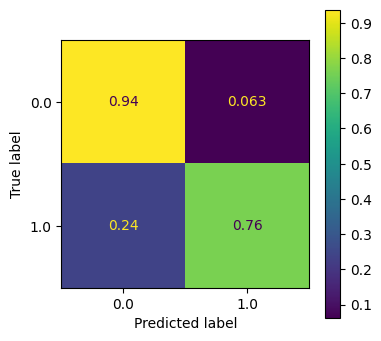

In [63]:
print(metrics.confusion_matrix(y_valid, predict_final))
cm = metrics.confusion_matrix(y_valid, predict_final, labels=lgbm.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgbm.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


## Catboost

In [65]:
catboost = CatBoostClassifier()
catboost.fit(x_train_full, y_train)

Learning rate set to 0.05122
0:	learn: 0.6280156	total: 241ms	remaining: 4m
1:	learn: 0.5742245	total: 326ms	remaining: 2m 42s
2:	learn: 0.5253221	total: 404ms	remaining: 2m 14s
3:	learn: 0.4850611	total: 486ms	remaining: 2m
4:	learn: 0.4469201	total: 580ms	remaining: 1m 55s
5:	learn: 0.4154769	total: 662ms	remaining: 1m 49s
6:	learn: 0.3870178	total: 744ms	remaining: 1m 45s
7:	learn: 0.3584825	total: 826ms	remaining: 1m 42s
8:	learn: 0.3362902	total: 912ms	remaining: 1m 40s
9:	learn: 0.3140347	total: 1s	remaining: 1m 39s
10:	learn: 0.2963073	total: 1.08s	remaining: 1m 37s
11:	learn: 0.2836779	total: 1.17s	remaining: 1m 36s
12:	learn: 0.2712687	total: 1.26s	remaining: 1m 35s
13:	learn: 0.2593328	total: 1.34s	remaining: 1m 34s
14:	learn: 0.2473929	total: 1.42s	remaining: 1m 33s
15:	learn: 0.2383574	total: 1.51s	remaining: 1m 32s
16:	learn: 0.2311288	total: 1.59s	remaining: 1m 32s
17:	learn: 0.2230318	total: 1.67s	remaining: 1m 31s
18:	learn: 0.2157577	total: 1.75s	remaining: 1m 30s
19:	

In [67]:
catboost_predictions = catboost.predict(x_valid_full)
print(metrics.f1_score(y_valid, catboost_predictions))

0.5392231530845393


In [68]:
catboost_predict_proba = cross_val_predict(catboost, x_valid_full, y_valid, cv=2, method='predict_proba')
print(catboost_predict_proba)

Learning rate set to 0.023831
0:	learn: 0.6620696	total: 62ms	remaining: 1m 1s
1:	learn: 0.6340364	total: 125ms	remaining: 1m 2s
2:	learn: 0.6079961	total: 193ms	remaining: 1m 4s
3:	learn: 0.5829797	total: 266ms	remaining: 1m 6s
4:	learn: 0.5592801	total: 343ms	remaining: 1m 8s
5:	learn: 0.5379767	total: 406ms	remaining: 1m 7s
6:	learn: 0.5176994	total: 466ms	remaining: 1m 6s
7:	learn: 0.4988488	total: 530ms	remaining: 1m 5s
8:	learn: 0.4811703	total: 592ms	remaining: 1m 5s
9:	learn: 0.4643673	total: 653ms	remaining: 1m 4s
10:	learn: 0.4491387	total: 714ms	remaining: 1m 4s
11:	learn: 0.4348295	total: 776ms	remaining: 1m 3s
12:	learn: 0.4194744	total: 839ms	remaining: 1m 3s
13:	learn: 0.4066275	total: 901ms	remaining: 1m 3s
14:	learn: 0.3939491	total: 961ms	remaining: 1m 3s
15:	learn: 0.3814997	total: 1.02s	remaining: 1m 3s
16:	learn: 0.3706081	total: 1.09s	remaining: 1m 3s
17:	learn: 0.3601822	total: 1.16s	remaining: 1m 3s
18:	learn: 0.3484179	total: 1.22s	remaining: 1m 2s
19:	learn: 0

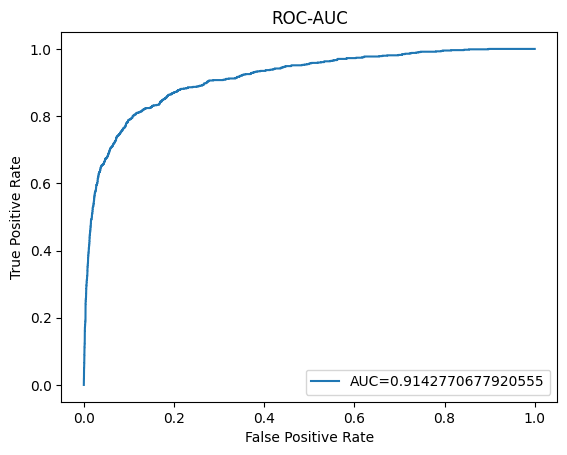

<Figure size 600x400 with 0 Axes>

In [69]:
catboost_predict_proba1 = catboost_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, catboost_predict_proba1)
auc = metrics.roc_auc_score(y_valid, catboost_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

In [70]:
f1_score = 0.0
threshold = 0.1
for thresh in range(1, 10):
    predict_cv_proba = (catboost_predict_proba1 >= thresh/10).astype(bool) 
    print(metrics.f1_score(y_valid, predict_cv_proba))
    if f1_score<metrics.f1_score(y_valid, predict_cv_proba):
        threshold = thresh/10
        f1_score = metrics.f1_score(y_valid, predict_cv_proba)
print(threshold)

0.5761099365750528
0.5630810092961487
0.5019127773527161
0.4504950495049504
0.41114982578397213
0.3572744014732964
0.2873900293255132
0.19117647058823528
0.09630459126539755
0.1


In [71]:
predict_catboost = catboost.predict(x_valid_full)
print(predict_catboost)
print(predict_catboost.sum())
print(y_valid.sum())
print(metrics.f1_score(y_valid, predict_catboost))

[0. 0. 0. ... 0. 0. 0.]
472.0
841.0
0.5392231530845393


In [72]:
predict_final = (catboost.predict_proba(x_valid_full)[:,1] >= threshold).astype(bool) 
print(predict_final)
print(predict_final.sum())
print(y_valid.sum())
print(metrics.f1_score(y_valid, predict_final))

[False False  True ... False False False]
1398
841.0
0.5690040196516303


[[12655   761]
 [  204   637]]


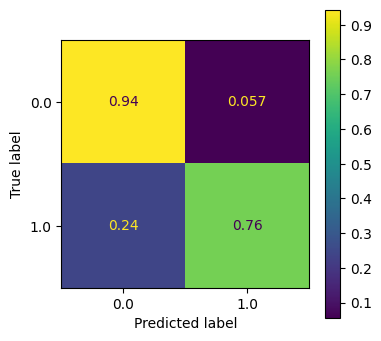

In [73]:
print(metrics.confusion_matrix(y_valid, predict_final))
cm = metrics.confusion_matrix(y_valid, predict_final, labels=catboost.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=catboost.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left"> Лучшей моделью оказалась CatBoost с отсечкой на 10%. При этом она дает много ложно-положительных предсказаний, но нам важнее верно-положительные прогнозы. Берем ее для прогноза на тестовых данных.

# Предсказания на тесте

In [83]:
x_last_train_full = np.concatenate((x_train_full, x_valid_full), axis=0)
print(len(x_last_train_full))
print(len(x_last_train_full[1]))
y_last_train_full = np.concatenate((y_train, y_valid), axis=0)
print(len(y_last_train_full))


57029
770
57029


In [84]:
catboost.fit(x_last_train_full, y_last_train_full)

Learning rate set to 0.057914
0:	learn: 0.6199145	total: 96.5ms	remaining: 1m 36s
1:	learn: 0.5603349	total: 193ms	remaining: 1m 36s
2:	learn: 0.5072896	total: 284ms	remaining: 1m 34s
3:	learn: 0.4631665	total: 374ms	remaining: 1m 33s
4:	learn: 0.4190444	total: 471ms	remaining: 1m 33s
5:	learn: 0.3853034	total: 561ms	remaining: 1m 32s
6:	learn: 0.3582032	total: 649ms	remaining: 1m 32s
7:	learn: 0.3300370	total: 743ms	remaining: 1m 32s
8:	learn: 0.3055437	total: 837ms	remaining: 1m 32s
9:	learn: 0.2880051	total: 929ms	remaining: 1m 32s
10:	learn: 0.2736344	total: 1.02s	remaining: 1m 31s
11:	learn: 0.2582645	total: 1.11s	remaining: 1m 31s
12:	learn: 0.2458118	total: 1.2s	remaining: 1m 31s
13:	learn: 0.2359540	total: 1.29s	remaining: 1m 30s
14:	learn: 0.2269065	total: 1.38s	remaining: 1m 30s
15:	learn: 0.2191909	total: 1.47s	remaining: 1m 30s
16:	learn: 0.2115739	total: 1.56s	remaining: 1m 30s
17:	learn: 0.2059449	total: 1.65s	remaining: 1m 30s
18:	learn: 0.1994441	total: 1.74s	remaining:

In [85]:
predict_test = (catboost.predict_proba(x_test_full)[:,1] >= threshold).astype(bool) 
print(predict_test)
print(predict_test.sum())
print(y_test.sum())
print(metrics.f1_score(y_test, predict_test))

[False False False ... False False False]
1426
841.0
0.5734450816056462


[[12641   776]
 [  191   650]]


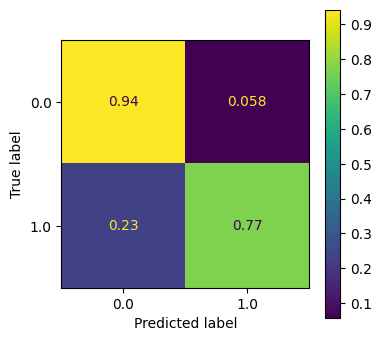

In [86]:
print(metrics.confusion_matrix(y_test, predict_test))
cm = metrics.confusion_matrix(y_test, predict_test, labels=catboost.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=catboost.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #294B8E"> Заключение</p>

<ul>
<li>Для определения каверов в массиве музыкальных композиций были предоставлены данные о 70 тыс песен</li>
<li>Данные были загружены, обработаны, для обучения ML моделей использовался год регистрации композиции, длительность и название</li>
<li>Численные данные были масштабированы, текстовые векторизованы с помощью преобученной модели BERT</li>
<li>На предоставленых данных было обучено три ML модели, наилучшие показатели по метрике F1 дала CatBoost</li>
<li>Выбранная ML модель провела предсказания на тестовом наборе данных</li>
</ul>    

    итоговая метрика F1_score составила 0.5734450816056462
    

